# Estimating Gender Discrimination in the Workplace
In this exercise we’ll use data from the 2018 US Current Population Survey (CPS) to try and estimate the effect of being a woman on workplace compensation. Note that our focus will be only on differential compensation in the work place, and as a result it is important to bear in mind that our estimates are not estimates of all forms of gender discrimination. For example, these analyses will not account for things like gender discrimination in terms of getting jobs.

In [45]:
import pandas as pd

# Load survey
df = pd.read_stata('./data/morg18.dta')
df.head()

,county,smsastat,age,sex,grade92,race,ethnic,marital,uhourse,earnhre,...,yrcoll,grprof,gr6cor,ms123,occ2012,lfsr94,class94,unioncov,ind02,stfips
0,0,1.0,71,1,42,1,NaN,1,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,Disabled-Not In Labor Force,,,,AL
1,0,1.0,64,2,40,1,NaN,1,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,Retired-Not In Labor Force,,,,AL
2,0,1.0,52,2,39,2,NaN,5,40.0,2084.0,...,NaN,NaN,NaN,NaN,5700.0,Employed-At Work,Government - State,,"Residential care facilities, without nursing (...",AL
3,0,1.0,19,2,39,2,NaN,7,40.0,1000.0,...,NaN,NaN,NaN,NaN,5240.0,Employed-At Work,"Private, For Profit",No,Business support services (5614),AL
4,0,1.0,56,2,43,2,NaN,5,40.0,2500.0,...,NaN,NaN,NaN,NaN,3255.0,Employed-At Work,Government - Federal,,Hospitals (622),AL


## Exercise 2
Because our interest is only in-the-workplace wage discrimination among full-time workers, we need to start by subsetting our data for people currently employed at the time of this survey using the lfsr94 variable, who are employed full time (meaning that their usual hours per week – uhourse – is 35 or above).

As noted above, this analysis will miss many forms of gender discrimination. For example, in dropping anyone who isn’t working, we immediately lose any women who couldn’t get jobs, or who chose to lose the workforce because the wages they were offered (which were likely lower than those offered men) were lower than they were willing / could accept. And in focusing on full time employees, we miss the fact women may not be offered full time jobs at the same rate as men.

In [46]:
df = df[df.lfsr94 == 'Employed-At Work']
df = df[df.uhourse >= 35]

df.shape

(133814, 25)

## Exercise 3
Now let’s estimate the basic wage gap for the United States!

Earnings per hour worked can be found in the earnhre variable. Two things are worth noting about this variable:

- It is coded in cents (1/100 of a dollar), not dollars, so make sure to divide by 100 to get dollars.

- Earnings are “top-coded” at 9999 (meaning any value above 99.99 dollars an hour is coded as 99.99 dollars an hour). Thankfully these are rare, so we’ll just leave them in as-is for now. However, note that wage inequality is likely to be especially high for extremely high paid individuals (e.g. most CEOs are men), so this will bias us towards slightly conservative (low) estimates of the gender wage gap.

Using the variable sex (1=Male, 2=Female), estimate the gender wage gap in terms of wages per hour worked!

In [47]:
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

# Adjust earnings per hour (in cents) into dollars,
df['earnhre_dollars'] = df['earnhre'] / 100
df['female'] = (df.sex == 2).astype('int')


# Compare
mean_female =  df[df['female']==1]["earnhre_dollars"].mean()
mean_male =  df[df['female']==0]["earnhre_dollars"].mean()

t_test = ttest_ind(df[df['female']==1]["earnhre_dollars"],
                   df[df['female']==0]["earnhre_dollars"],
                   nan_policy = "omit")

print("Female average per hour wage : {:.2f}".format(mean_female))
print("Male average per hour wage : {:.2f}".format(mean_male))
print("Difference between genders : {:.2f}".format(mean_male-mean_female))
print("P-value : {:.4f}".format(t_test[1]))


Female average per hour wage : 18.08
Male average per hour wage : 20.55
Difference between genders : 2.48
P-value : 0.0000


In [48]:
ttest_ind(df[df['female']==1]["earnhre_dollars"],
          df[df['female']==0]["earnhre_dollars"],
          nan_policy = "omit")[1]

8.839043304718214e-218

**Answer：** There is a significant (p-value < 0.0000) difference of per hour wage between males and females. The average per hour wage gap is 2.48 dollars.

## Exercise 4
The variable uhourse is the number of hours that the respondent usually works per week. What is the wage gap not per hour, but per year? Is the difference statistically significant?

In [49]:
df['annual_earnings'] = df['earnhre_dollars'] * df['uhourse'] * 52

# Compare
mean_female =  df[df['female']==1]["annual_earnings"].mean()
mean_male =  df[df['female']==0]["annual_earnings"].mean()

t_test = ttest_ind(df[df['female']==1]["annual_earnings"],
                   df[df['female']==0]["annual_earnings"],
                   nan_policy = "omit")

print("Female average annual wage : {:.2f}".format(mean_female))
print("Male average annual wage : {:.2f}".format(mean_male))
print("Difference between genders : {:.2f}".format(mean_male-mean_female))
print("P-value : {:.4f}".format(t_test[1]))

Female average annual wage : 37864.64
Male average annual wage : 45105.30
Difference between genders : 7240.67
P-value : 0.0000


**Answer：**
There is a significant (p-value < 0.0000) difference of annual wage between males and females. The average per hour wage gap is 7240.67 dollars.

## Exercise 5
We just compared all full-time working men to all full-time working women. For this to be an accurate causal estimate of the effect of being a woman in the work place, what must be true of these two groups? What is one reason that this may not be true?

Text(0.5, 1.0, 'Male age distribution')

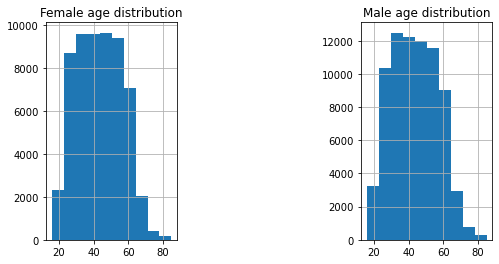

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.subplot(1,3,1)
df[df['female']==1]["age"].hist()
plt.title('Female age distribution')

plt.subplot(1,3,3)
df[df['female']==0]["age"].hist()
plt.title('Male age distribution')


**Answer：**  Age is a potential factor may affect the comparison, because veterans tend to receive more salaries than a rookie. To get an accurate causal estimate, we must eliminate this difference from age. According to the charts, the two groups' age distribution is similar; however, advanced analysis is necessary. 

## Exercise 6
One answer to the second part of Exercise 5 is that working women are likely to be younger, since a larger portion of younger women are entering the workforce as compared to older generations.

**Answer：** To control for this difference, let’s now regress annual earnings on gender and age. What is the implied average annual wage difference between women and men? Is it different from your raw estimate? Is the difference statistically significant?

In [51]:
smf.ols('annual_earnings ~ female + age', df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1974.
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:03:58   Log-Likelihood:            -7.5225e+05
No. Observations:               65755   AIC:                         1.504e+06
Df Residuals:                   65752   BIC:                         1.505e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.265e+04    288.243    113.284      0.000    3.21e+04    3.32e+04
female     -7557.2936    176.107    -42.913      0.000   -7902.462   -7212.125
age          304.1829      6.406     47.485      0.000     291.627     316.738
==============================================================================
Omnibus:                    33771.778   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           307310.621
Skew:                           2.305   Prob(JB):                         0.00
Kurtosis:                      12.535   Cond. No.                         146.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Answer：** The implied average annual wage difference between women and men is 7557 dollars. Since the p-value is less than 0.001, the result is statistically significant. The difference is larger than the raw estimate of 7240 dollars.

## Exercise 7
In running this regression and interpreting the coefficient on female, what is the implicit comparison you are making? In other words, when we run this regression and interpreting the coefficient on female, we’re basically pretending we are comparing two groups and assuming they are counter-factuals for one another. What are these two groups?

**Answer：**   We are interpreting the implicit comparison of women versus men with the same age in the model.  Strictly speaking, it should be female and non-female. Still, in this dataset, the sex item only has two alternatives: men and women. 

# Exercise 8
Now let’s add to our regression an indicator variable for whether the respondent has at least graduated high school, and an indicator for whether the respondent at least has a BA.

In answering this question, use the following table of codes for the variable grade92.

Education is coded as follows:

![cps_educ_codes](./img/cps_educ_codes.png)  

In [52]:
df['high_school'] = (df.grade92 >= 39).astype('int')
df['ba'] = (df.grade92 >= 42).astype('int')

print("Number of high_school is {}, BA is {}.".
      format(sum(df['high_school']), sum(df['ba'])))

Number of high_school is 125640, BA is 62617.


In [53]:
smf.ols('annual_earnings ~ female + age + high_school + ba', df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2786.
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:04:44   Log-Likelihood:            -7.4902e+05
No. Observations:               65755   AIC:                         1.498e+06
Df Residuals:                   65750   BIC:                         1.498e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.139e+04    381.994     56.003      0.000    2.06e+04    2.21e+04
female      -9432.7984    169.206    -55.747      0.000   -9764.443   -9101.154
age           306.2583      6.101     50.197      0.000     294.300     318.217
high_school  9121.8502    296.897     30.724      0.000    8539.932    9703.768
ba           1.312e+04    189.998     69.056      0.000    1.27e+04    1.35e+04
==============================================================================
Omnibus:                    31930.498   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           289837.885
Skew:                           2.144   Prob(JB):                         0.00
Kurtosis:                      12.349   Cond. No.                         234.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Answer：**  This model shows that having at least a high_school degree would increase the salary by 9121 dollars. At least a bachelor's degree would increase the wage by 13120 dollars. The two effects are all statistically significant. However, females' annual salary is significantly lower than men by 9432 dollars.  

## Exercise 9
In running this regression and interpreting the coefficient on female, what is the implicit comparison you are making? In other words, when we run this regression and interpreting the coefficient on female, we are once more basically pretending we are comparing two groups and assuming they are counter-factuals for one another. What are these two groups?

**Answer：** We are comparing annual salary between male and female of the same age and education.

## Exercise 10
Given how the coefficient on female has changed between Exercise 6 and Exercise 8, what can you infer about the educational attainment of the women in your survey data (as compared to the educational attainment of men)?

In [54]:
print("Number of male high_school is {}, BA is {}.".
      format(sum(df[df["female"] == 0]['high_school']), sum(df[df["female"] == 0]['ba'])))

print("Number of female high_school is {}, BA is {}.".
      format(sum(df[df["female"] == 1]['high_school']), sum(df[df["female"] == 1]['ba'])))

Number of male high_school is 69353, BA is 31955.
Number of female high_school is 56287, BA is 30662.


## Exercise 11
What does that tell you about the potential outcomes of men and women before you added education as a control?

**Answer：** 
- Potential of men:

## Exercise 12
Finally, let’s include fixed effects for the type of job held by each respondent.

Fixed effects are a method used when we have a nested data structure in which respondents belong to groups, and those groups may all be subject to different pressures. In this context, for example, we can add fixed effects for the industry of each respondent – since wages often vary across industries, controlling for industry is likely to improve our estimates.

(Note that fixed effects are very similar in principle to hierarchical models. There are some differences you will read about for our next class, but they are designed to serve the same role, just with slightly different mechanics).

When we add fixed effects for groups like this, our interpretation of the other coefficients changes. Whereas in previous exercises we were trying to explain variation in men and women’s wages across all respondents, we are now effectively comparing men and women’s wages within each employment sector. Our coefficient on female, in other words, now tells us how much less (on average) we would expect a woman to be paid than a man within the same industry, not across all respondents.

(Note that running this regression will result in lots of coefficients popping up you don’t care about. We’ll introduce some more efficient methods for adding fixed effects that aren’t so messy in a later class – for now, you can ignore those coefficients!)

In [55]:
#from linearmodels import PanelOLS
#
#df_multiindex = df.set_index(['ind02', df.index])
#
#mod = PanelOLS.from_formula('annual_earnings ~ female + age + high_school + ba + EntityEffects',
#                            data=df_multiindex)
#mod.fit(cov_type='clustered', cluster_entity=True)

In [56]:
df.reset_index(drop=True, inplace=True)
smf.ols('annual_earnings ~ female + age + high_school + ba + C(ind02)', df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     76.79
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:05:10   Log-Likelihood:            -7.4559e+05
No. Observations:               65755   AIC:                         1.492e+06
Df Residuals:                   65500   BIC:                         1.494e+06
Df Model:                         254                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================================================
                                                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                 1.944e+04    718.430     27.060      0.000     1.8e+04    2.08e+04
C(ind02)[T.** Alcoholic beverages, merchant wholesalers (*4248)]                                                         -3842.2119   3133.897     -1.226      0.220   -9984.651    2300.228
C(ind02)[T.** Apparel, fabrics, and notions, merchant wholesalers (*4243)]                                                -570.6959   3006.218     -0.190      0.849   -6462.885    5321.493
C(ind02)[T.** Construction (23)]                                                                                          1.196e+04    680.641     17.567      0.000    1.06e+04    1.33e+04
C(ind02)[T.** Drugs, sundries, and chemical and allied products, merchant (wholesalerss*4242, 4246)]                      5767.8298   2403.874      2.399      0.016    1056.235    1.05e+04
C(ind02)[T.** Farm product raw materials, merchant wholesalers (*4245)]                                                  -1264.7498   2816.737     -0.449      0.653   -6785.554    4256.055
C(ind02)[T.** Farm supplies, merchant wholesalers (*42491)]                                                               -580.5447   3900.320     -0.149      0.882   -8225.173    7064.083
C(ind02)[T.** Furniture and home furnishing, merchant wholesalers (*4232)]                                                 903.5353   4204.933      0.215      0.830   -7338.135    9145.206
C(ind02)[T.** Groceries and related products, merchant wholesalers (*4244)]                                                738.1672   1174.009      0.629      0.530   -1562.890    3039.225
C(ind02)[T.** Lumber and other construction materials, merchant wholesalers (*4233)]                                      1417.0565   2247.477      0.631      0.528   -2987.999    5822.112
C(ind02)[T.** Machinery, equipment, and supplies, merchant wholesalers (*4238)]                                           5654.9112   1694.885      3.336      0.001    2332.937    8976.886
C(ind02)[T.** Mail order houses (*454113)]                                                                                 668.3939   3452.451      0.194      0.846   -6098.410    7435.198
C(ind02)[T.** Metals and minerals, except petroleum, merchant wholesalers (*4235)]                                        -562.7904   4489.679     -0.125      0.900   -9362.562    8236.981
C(ind02)[T.** Miscellaneous (nondurable goods, merchant who

**Answer：** According to the model, women will receive 7329 dollars less than men on average. The result is statistically significant.

## Exercise 13
Now that we’ve added industry fixed effects, what groups are we implicitly treated as counter-factuals for one another now?

**Answer：**  We are comparing annual salary between male and female of the same age, education and in the same industry.

## Exercise 14
What happened to your estimate of the gender wage gap when you added industry fixed effects? What does that tell you about the industries chosen by women as opposed to men?

**Answer：** 